In [1057]:
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.5 MB 298 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [1058]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1059]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1060]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1061]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1062]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from pandas.core.common import random_state

import spacy
import en_core_web_md
import nltk
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter, defaultdict

import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten, SimpleRNN, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from livelossplot import PlotLossesKeras

import gradio as gr



In [1063]:
df = pd.read_csv('/content/drive/MyDrive/df_klasyfikacja_shared_march.csv')

In [1064]:
df

,Unnamed: 0,section,byline,title,abstract,class,print_page,pub_date,type_of_material
0,0,Technology,By Davey Alba and Stuart A. Thompson,‘I’ll Stand on the Side of Russia’: Pro-Putin ...,After marinating in conspiracy theories and Do...,top,NaN,NaN,NaN
1,1,U.S.,"By David E. Sanger, Julian E. Barnes and Kate ...","As Tanks Rolled Into Ukraine, So Did Malware. ...",After years of talks about the need for public...,top,11.0,2022-03-01T00:50:58+0000,News
2,2,World,"By David D. Kirkpatrick, Maggie Astor and Cati...","Trump Praises Putin, Leaving Republicans in a ...","G.O.P. leaders, while condemning Russia’s inva...",top,NaN,NaN,NaN
3,3,Movies,By Alex Marshall,"Gérard Depardieu, Friend of Putin, Denounces ‘...","“Stop the weapons and negotiate,” the French a...",top,7.0,2022-03-01T16:06:52+0000,News
4,4,Health,By Apoorva Mandavilli,New C.D.C. Guidelines Suggest 70 Percent of Am...,The agency issued a new set of recommendations...,top,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4117,4117,Food,By Tejal Rao,Vegetarian Pastas I’m Craving,"After some time away from home, nothing satisf...",all,NaN,2022-03-31T17:00:04+0000,News
4118,4118,U.S.,By Ellen Barry,Many Teens Report Emotional and Physical Abuse...,New data on teen mental health during the pand...,all,NaN,2022-03-31T17:00:10+0000,News
4119,4119,Technology,By Shira Ovide,Hugs to Boring,Don’t underestimate the tech that makes your e...,all,NaN,2022-03-31T17:01:32+0000,News
4120,4120,Theater,By Jesse Green,"Review: In ‘I Agree to the Terms,’ It’s Rainin...",The Builders Association explores the world of...,all,NaN,2022-03-31T17:04:43+0000,Review


# Data Cleaning

In [1065]:
df = df.dropna(subset = ['title', 'abstract', 'byline'])

In [1066]:
df.drop_duplicates(subset=['title', 'abstract'], inplace=True) #default keep first

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1067]:
df = df.reset_index()

In [1068]:
df.drop(['index', 'Unnamed: 0'], axis=1, inplace=True) #usuwanie niepotrzebnych kolumn

In [1069]:
df['byline'] = df['byline'].apply(lambda x: x[3:])  #usuwanie "By " z byline, żeby zostało tylko nazwisko autora

In [1070]:
#df = df[pd.isnull(df['type_of_material']) != True]

In [1071]:
df['print_page'] = df['print_page'].fillna(0)

In [1072]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3899 entries, 0 to 3898
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   section           3899 non-null   object 
 1   byline            3899 non-null   object 
 2   title             3899 non-null   object 
 3   abstract          3899 non-null   object 
 4   class             3899 non-null   object 
 5   print_page        3899 non-null   float64
 6   pub_date          3761 non-null   object 
 7   type_of_material  3761 non-null   object 
dtypes: float64(1), object(7)
memory usage: 243.8+ KB


ograniczenie zbioru all do 1000 próbek

In [1073]:
import random

In [1074]:
df[df['class']=='all'].index

Int64Index([ 210,  211,  212,  213,  214,  215,  216,  217,  218,  219,
            ...
            3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898],
           dtype='int64', length=3689)

In [1075]:
random.seed(1)
a = random.sample(range(210, 3898), 1000)

In [1076]:
df = pd.concat([df[df['class']=='top'],df.loc[a]])

# Feature Engineering

Text(0, 0.5, 'Liczba artykułów')

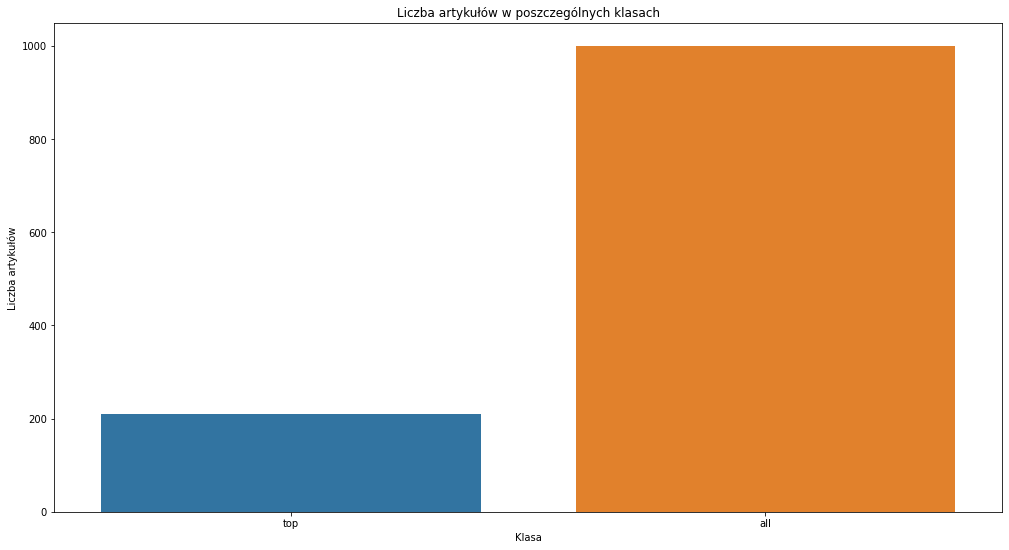

In [1077]:
#liczba artykułów w klasach
plt.figure(figsize=(17,9))
plt.title('Liczba artykułów w poszczególnych klasach')
ax = sns.countplot(x='class',data=df)
plt.xlabel('Klasa')
plt.ylabel('Liczba artykułów')

In [1078]:
klasy = {'all':0, 'top':1}
df['class_le'] = df['class'].map(klasy) 

In [1079]:
#byline, section, type_of_material - label encoding
le_byline = preprocessing.OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
#le_byline = preprocessing.LabelEncoder()
df['byline_le'] = le_byline.fit_transform(df['byline'].values.reshape(-1,1))
#print(le_byline.classes_)
#le_section = preprocessing.LabelEncoder()
le_section = preprocessing.OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
df['section_le'] = le_section.fit_transform(df['section'].values.reshape(-1,1))
#print(le_section.classes_)
#le_material = preprocessing.LabelEncoder()
le_material = preprocessing.OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
df['type_of_material_le'] = le_material.fit_transform(df['type_of_material'].values.reshape(-1,1))
df['type_of_material_le'] = df['type_of_material_le'].fillna(-2)

In [1080]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
nlp=en_core_web_md.load()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1081]:
#czyszczenie tytułu i abstraktu, usuwanie stopwords
df['title_clean']=df['title'].str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
df['abstract_clean']=df['abstract'].str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

Najczęstsze słowa w tytułach - klasa:  0


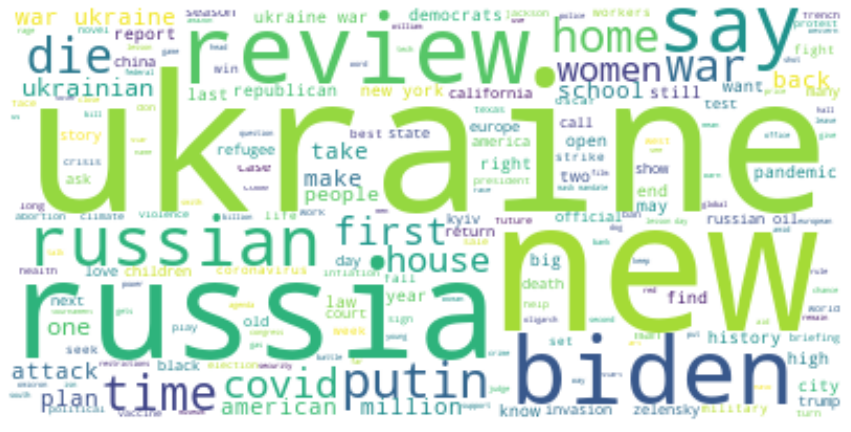

Najczęstsze słowa w tytułach - klasa:  1


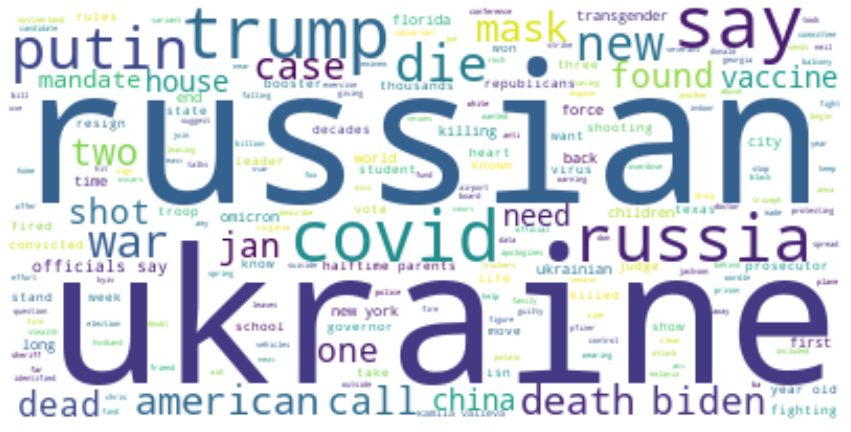

In [1082]:
l = [0, 1]
for i in l:
    dummy_df = df[df['class_le'] == l[i]]
    #Generate a word cloud image
    print('Najczęstsze słowa w tytułach - klasa: ',l[i])
    wordcloud = WordCloud(background_color="white",prefer_horizontal=1,relative_scaling=0.5).generate(' '.join(map(str, dummy_df['title_clean'])))
    #Display the generated image   
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Najczęstsze słowa w abstraktach - klasa:  0


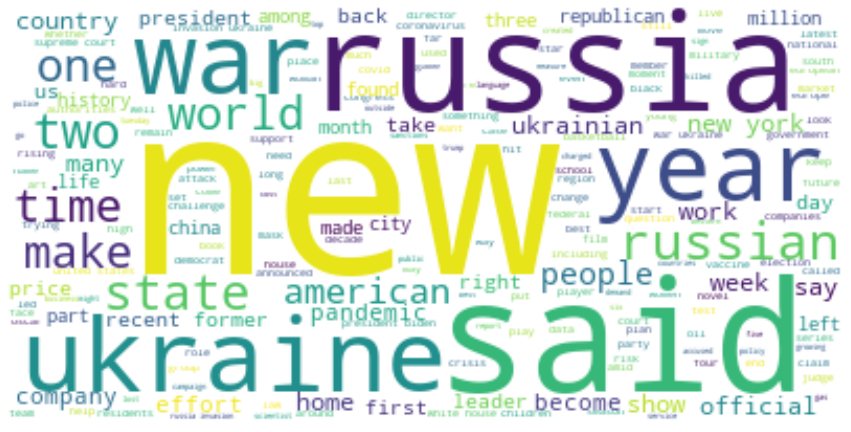

Najczęstsze słowa w abstraktach - klasa:  1


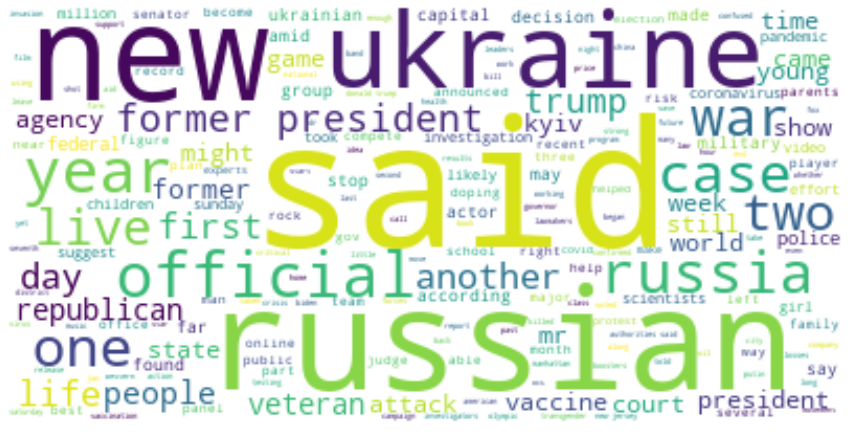

In [1083]:
l = [0, 1]
for i in l:
    dummy_df = df[df['class_le'] == l[i]]
    #Generate a word cloud image
    print('Najczęstsze słowa w abstraktach - klasa: ',l[i])
    wordcloud = WordCloud(background_color="white",prefer_horizontal=1,relative_scaling=0.5).generate(' '.join(map(str, dummy_df['abstract_clean'])))
    #Display the generated image   
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [1084]:
df['title_vec_avg']=df['title_clean'].map(nlp).map(lambda x: np.mean(x.vector))                                                       #średnia wektorów słów w danym tytule

In [1085]:
df['abstract_vec_avg']=df['abstract_clean'].map(nlp).map(lambda x: np.mean(x.vector))                                                 #średnia wektorów słów w danym abstrakcie

In [1086]:
df['title_len'] = df['title'].apply(lambda x: len(x.split()))                                                                         #liczba słów w tytule (długość tytułu)
df['abstract_len'] = df['abstract'].apply(lambda x: len(x.split()))                                                                   #liczba słów w abstrakcie (długość abstraktu)
def cap_lett(message):
  n=0
  for x in message:
    if x.isupper():
      n += 1
  return n
df['capital_letters'] = df['title'].apply(cap_lett)                                                                                   #liczba wielkich liter w tytule
df['title_punct_num'] = df['title'].apply(lambda x: len(''.join([word for word in x if word in string.punctuation])))                 #liczba wszystkich znaków interpunkcyjnych w tytule
df['abstract_punct_num'] = df['abstract'].apply(lambda x: len(''.join([word for word in x if word in string.punctuation])))           #liczba wszystkich znaków interpunkcyjnych w abstrakcie
df['title_!'] = df['title'].apply(lambda x: len(''.join([word for word in x if word == "!"])))                                        #liczba wykrzykników w tytule
df['abstract_!'] = df['abstract'].apply(lambda x: len(''.join([word for word in x if word == "!"])))                                  #liczba wykrzykników w abstrakcie
df['title_?'] = df['title'].apply(lambda x: len(''.join([word for word in x if word == "?"])))                                        #liczba znaków zapytania w tytule
df['abstract_?'] = df['abstract'].apply(lambda x: len(''.join([word for word in x if word == "?"])))                                  #liczba znaków zapytania w abstrakcie
df['authors_num'] = df['byline'].apply(lambda x: len(''.join([word for word in x if word == "," or word == 'and' or word == '&']))+1) #liczba autorów (+1, bo jeśli nie ma andów ani przecinków, to mamy jednego autora)
df['coauthors'] = np.where(df['authors_num'] > 1, 1, 0)                                                                               #czy jest więcej niż 1 autor

Text(0.5, 1.0, 'Liczba artykułów w poszczególnych sekcjach')

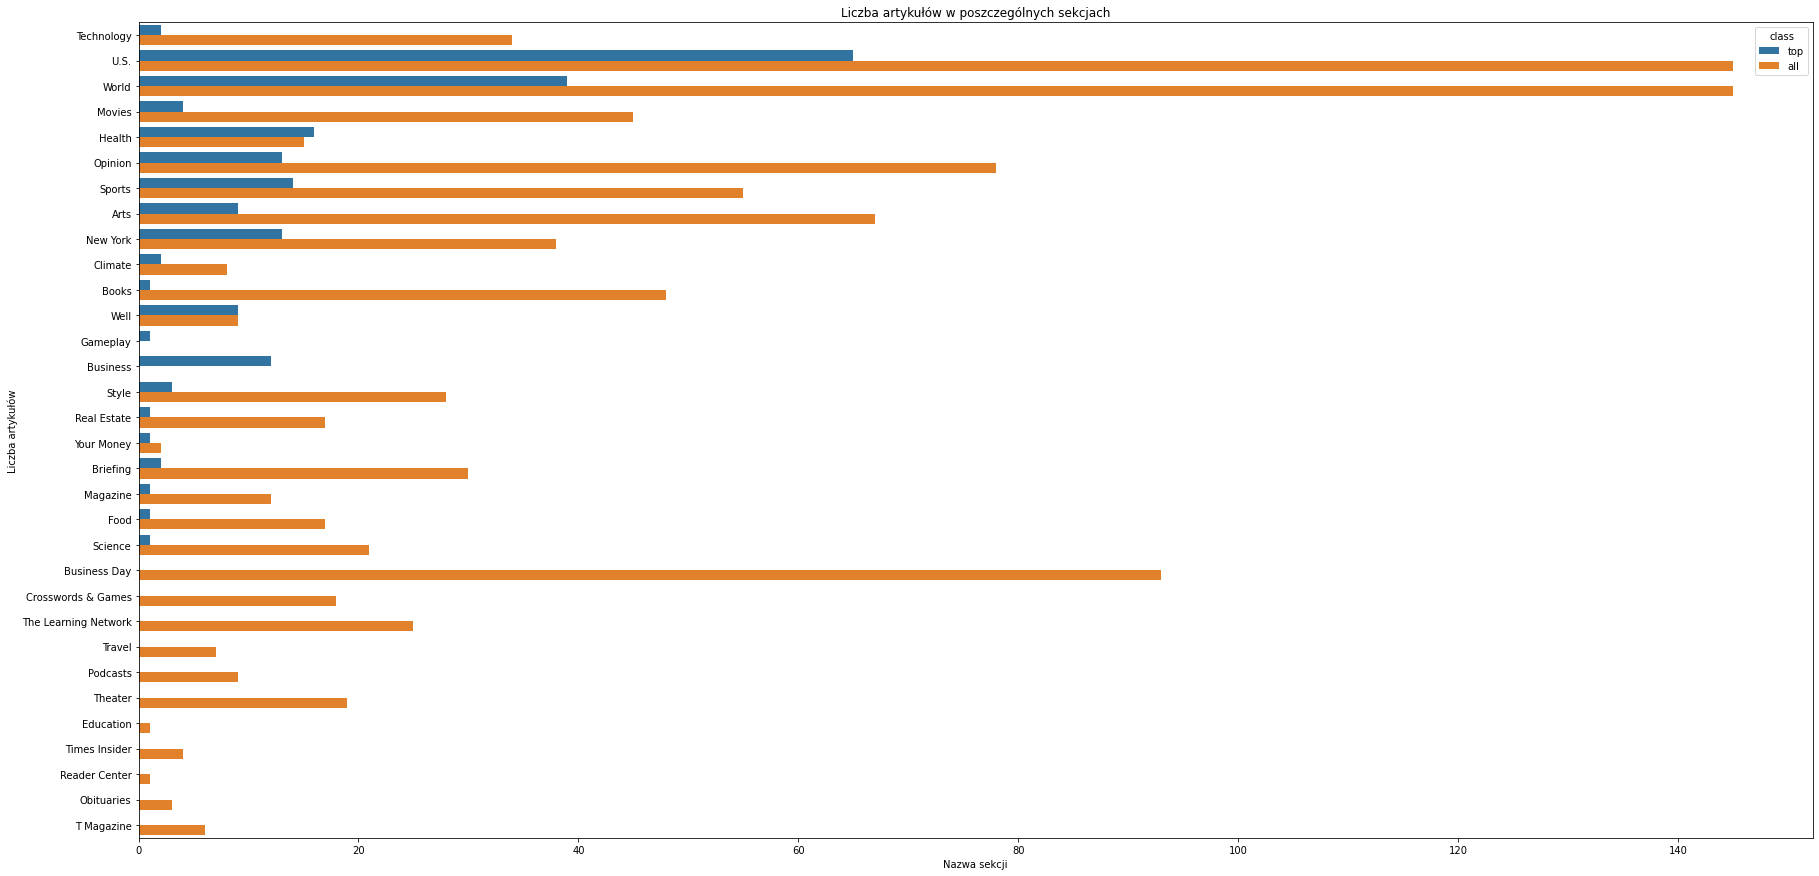

In [1163]:
plt.figure(figsize=(30,15))
ax = sns.countplot(y='section', hue='class', data=df)
plt.xlabel('Nazwa sekcji')
plt.ylabel('Liczba artykułów')
plt.title('Liczba artykułów w poszczególnych sekcjach')

In [1087]:
def group_sections(section): 
    if section in ('Sports', 'Books', 'Movies', 'Crosswords & Games', 'Theater', 'Arts'):   #entertainment
      return 1
    elif section in ('Health', 'Style', 'Food', 'Well', 'Travel', 'Fashion & Style', 'Home & Garden', 'T Magazine'): #lifestyle
      return 2 
    elif section in ('Technology', 'Climate', 'Science', 'Education'): #knowlegde
      return 3
    elif section in ('Business', 'You Money', 'Real Estate', 'Business Day', 'Briefing'): #business
      return 4 
    elif section == 'World':
      return 5
    elif section in ('U.S.', 'New York'):
      return 6
    return 7            #others
df['sections_grouped'] = df['section'].map(group_sections) 

In [1088]:
ent = df['title'].map(nlp).map(lambda x: x.ents)
df['title_ner'] = ent.map(lambda e: [en.text for en in e])          #NERy występujące w tytule

In [1089]:
df['title_ner_type'] = ent.map(lambda e: [en.label_ for en in e])   #rodzaje NERów w tytule

In [1090]:
df['ners_num'] = df['title_ner_type'].map(lambda x: len(x))     #liczba NERów w tytule

In [1091]:
def ners_GPE(x):
  for i in x:
    if i == 'GPE':
      return 1
    return 0

def ners_PERSON(x):
  for i in x:
    if i == 'PERSON':
      return 1
    return 0

def ners_ORG(x):
  for i in x:
    if i == 'ORG':
      return 1
    return 0

def ners_MONEY(x):
  for i in x:
    if i == 'MONEY':
      return 1
    return 0

def ners_NORP(x):
  for i in x:
    if i == 'NORP':
      return 1
    return 0

In [1092]:
df['ner_GPE'] = df['title_ner_type'].map(ners_GPE)
df['ner_PERSON'] = df['title_ner_type'].map(ners_PERSON)
df['ner_ORG'] = df['title_ner_type'].map(ners_ORG)
df['ner_MONEY'] = df['title_ner_type'].map(ners_MONEY)
df['ner_NORP'] = df['title_ner_type'].map(ners_NORP)
df['ner_GPE'] = df['ner_GPE'].fillna(0)
df['ner_PERSON'] = df['ner_PERSON'].fillna(0)
df['ner_ORG'] = df['ner_ORG'].fillna(0)
df['ner_MONEY'] = df['ner_MONEY'].fillna(0)
df['ner_NORP'] = df['ner_NORP'].fillna(0)

In [1093]:
df['pub_date'] = pd.to_datetime(df['pub_date'], errors='coerce')            #zmiana pub_date na format daty
df['pub_day_of_week'] = df['pub_date'].dt.day_of_week                       #dzień tygodnia, w którym opublikowany został artykuł

In [1094]:
df['pub_day_of_week'] = df['pub_day_of_week'].fillna(-1)

In [1095]:
sent = SentimentIntensityAnalyzer()
df['title_sentiment'] = df['title'].apply(lambda x: sent.polarity_scores(x)['compound'])          #analiza sentymentu tytułu
df['abstract_sentiment'] = df['abstract'].apply(lambda x: sent.polarity_scores(x)['compound'])    #analiza sentymentu abstraktu

In [1096]:
df.sample()

,section,byline,title,abstract,class,print_page,pub_date,type_of_material,class_le,byline_le,...,title_ner_type,ners_num,ner_GPE,ner_PERSON,ner_ORG,ner_MONEY,ner_NORP,pub_day_of_week,title_sentiment,abstract_sentiment
3564,U.S.,Ruth Graham,"Hillsong, Once a Leader of Christian Cool, Los...","Amid a series of crises, including the resigna...",all,22.0,2022-03-29 09:00:27+00:00,News,0,629.0,...,"[GPE, GPE]",2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.296


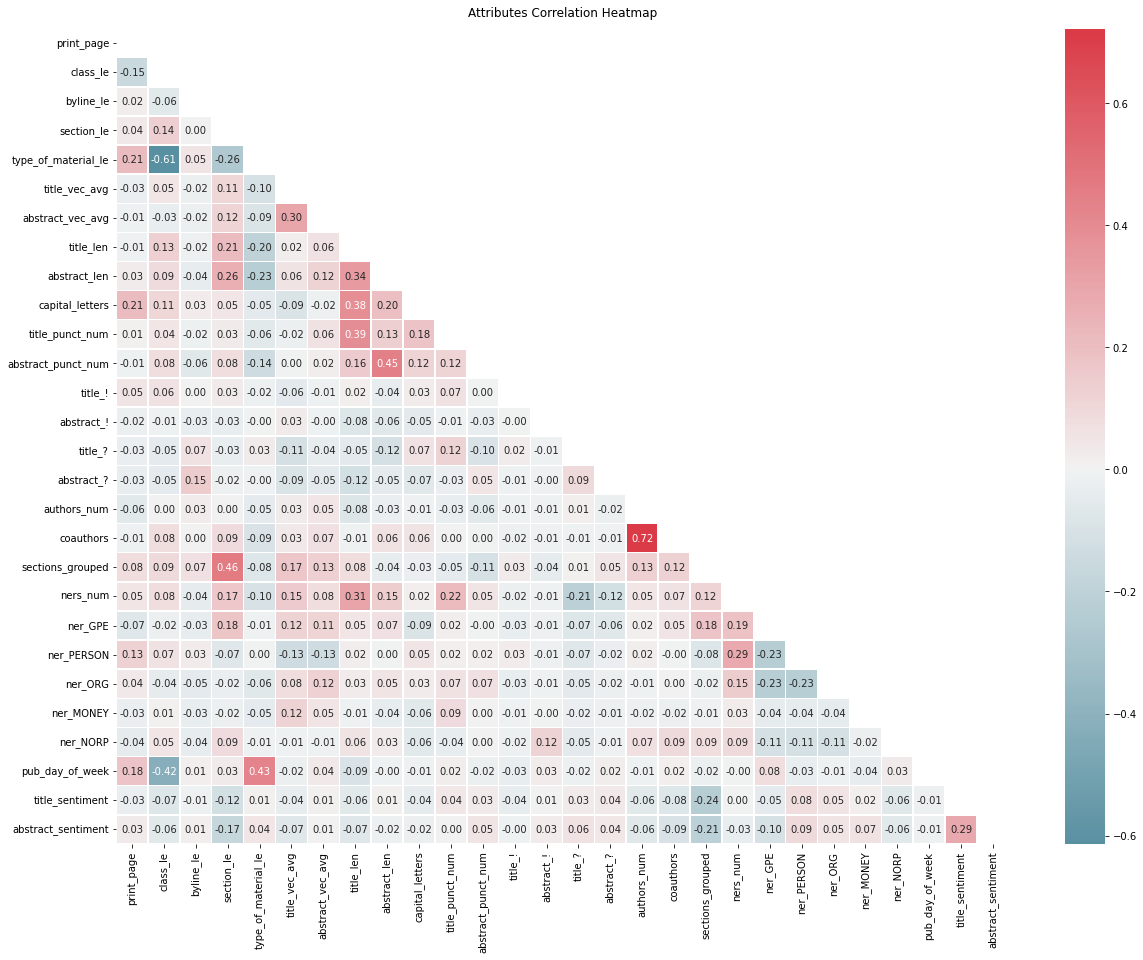

In [1097]:
plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(df.select_dtypes(np.number).corr()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(df.select_dtypes(np.number).corr(),
                      annot=True, cmap=cmap, mask=mask, center=0,
                      linewidths=.5, fmt='.2f');
heatmap.set_title('Attributes Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#Tworzenie modelu

In [1098]:
def get_feats(df, black_list=['class_le', 'index']):
    return [x for x in df.select_dtypes(['number', 'bool']).columns if x not in black_list]

def get_X_y(df, feats=None):
    if feats is None:
        feats = get_feats(df)
        
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(df[feats].values)
    le_y = preprocessing.LabelEncoder()
    y=le_y.fit_transform(df['class'].values)
    
    return X, y

X, y = get_X_y(df)

def model_train_predict(model, X, y, test_size=0.3):
    X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
    
    cv = KFold(n_splits=3, random_state=2021, shuffle=True)
    scores=[]
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        
    score = accuracy_score(y[test_idx], y_pred)
    scores.append(score)
    
    return score, y_pred, cv


In [1099]:
def run_cv_model(model_cls, model_params, X, y, feats, cv=KFold(n_splits=5, random_state=2021, shuffle=True), scoring='f1',
                 plot_learning_curve=True, plot_confusion_matrix=True, plot_feature_importances=True):

    scores = cross_val_score(model_cls(**model_params), X, y, cv=cv, scoring=scoring)
    print('mean={}, std={}, scores={}'.format( np.round(np.mean(scores), 2), np.round(np.std(scores), 2), scores))
    
    model = None
    if plot_learning_curve:
        model = model_cls(**model_params)
        model.fit(X, y)
        title='Learning Curve. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_learning_curve(model, X, y, title=title,figsize=(15, 5), cv=cv, scoring=scoring);
    
    if plot_confusion_matrix:
        y_pred = cross_val_predict(model_cls(**model_params), X, y, cv=cv)
        title='Confusion Matrix. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.metrics.plot_confusion_matrix(y, y_pred, title=title, normalize=True, figsize=(20 ,10))
    
    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X, y)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));    


mean=0.68, std=0.07, scores=[0.62222222 0.74418605 0.57534247 0.7032967  0.73469388]


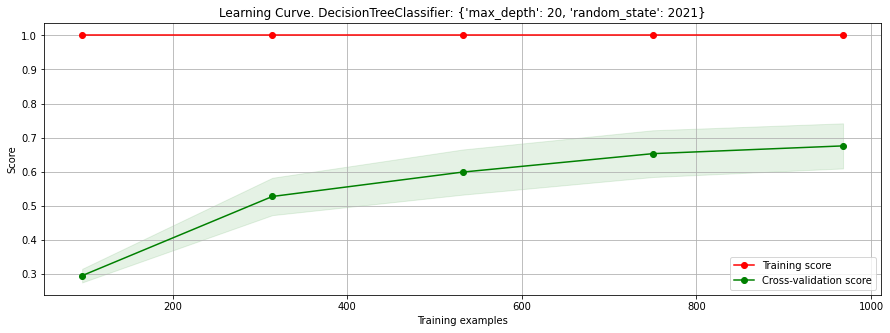

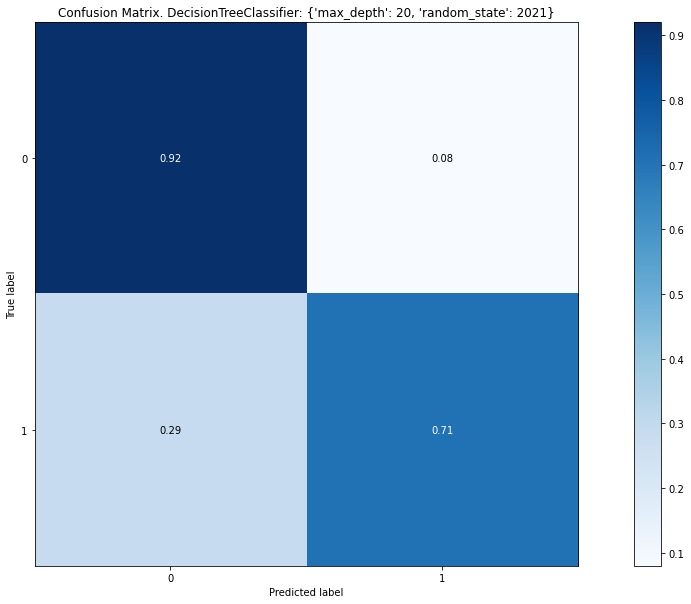

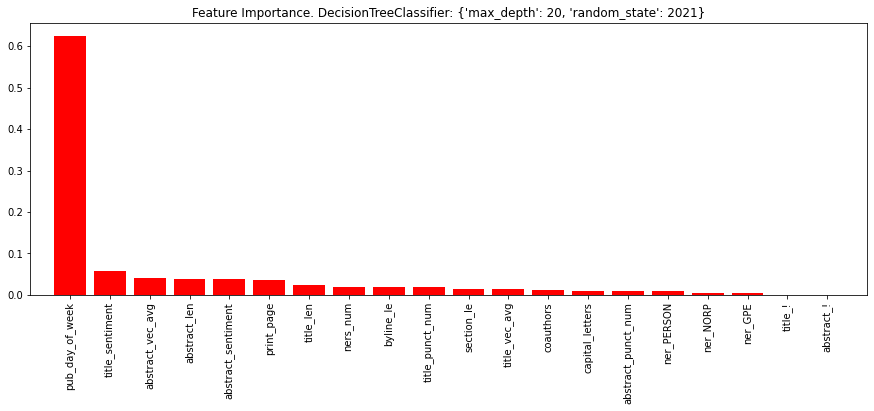

In [1100]:
run_cv_model(DecisionTreeClassifier, {'max_depth':20, 'random_state':2021}, X,y, get_feats(df))

mean=0.78, std=0.05, scores=[0.76470588 0.83333333 0.68965517 0.8        0.83116883]


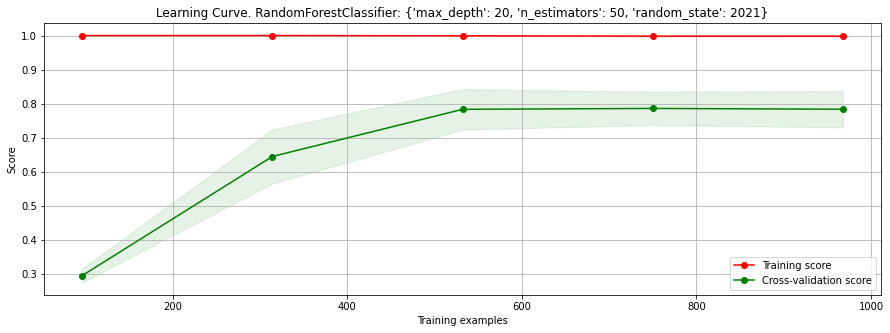

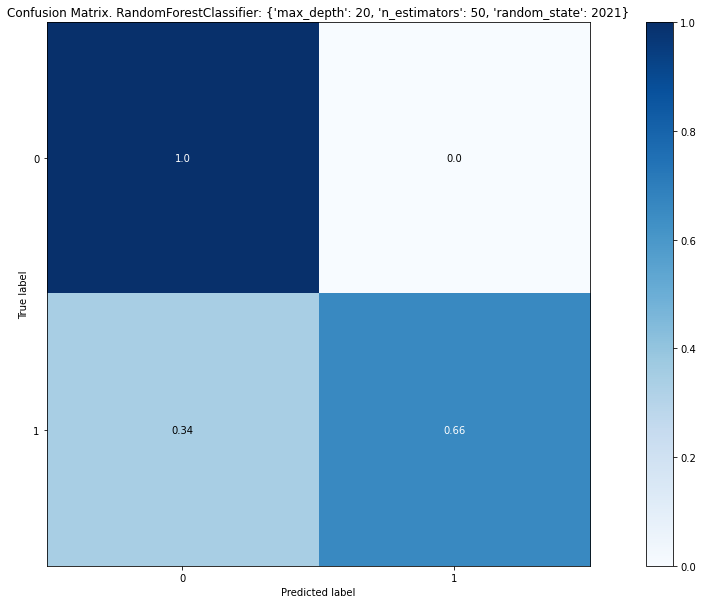

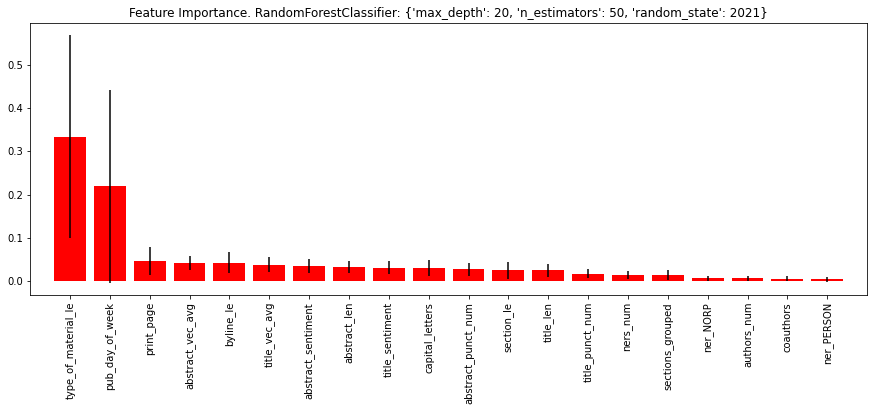

In [1101]:
run_cv_model(RandomForestClassifier, {'max_depth':20, 'n_estimators':50, 'random_state':2021}, X,y, get_feats(df))

mean=0.77, std=0.05, scores=[0.74285714 0.78947368 0.6779661  0.81578947 0.8       ]


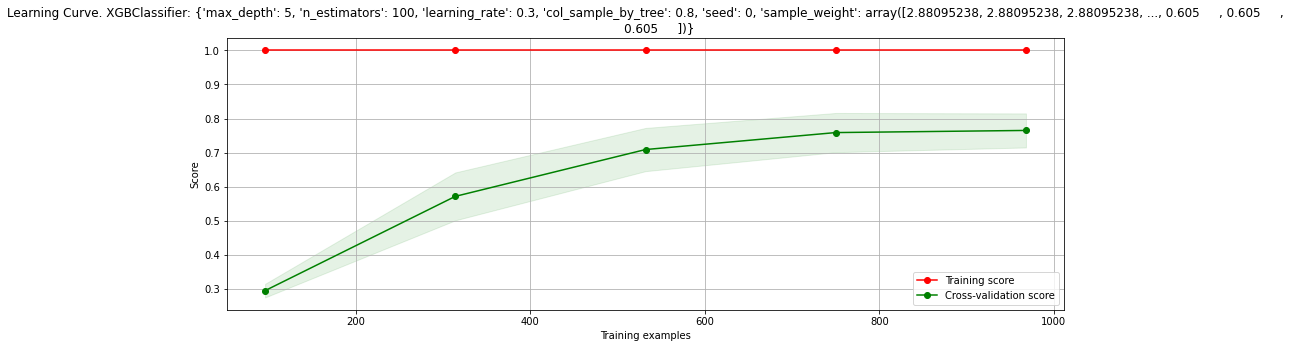

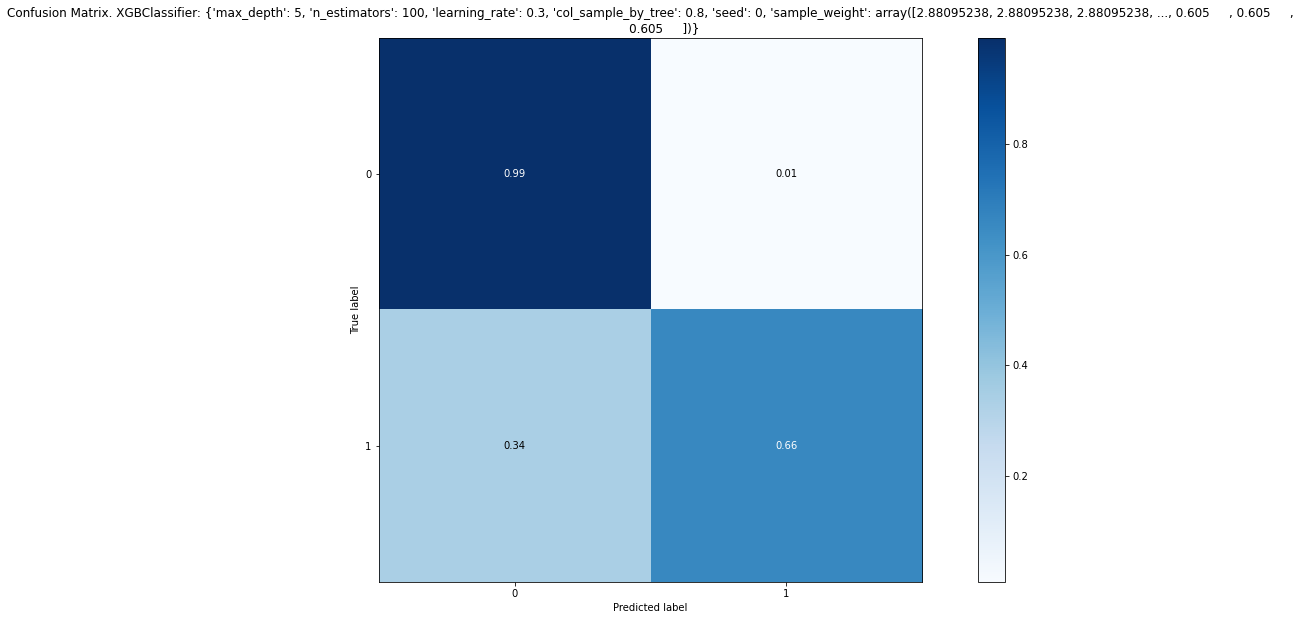

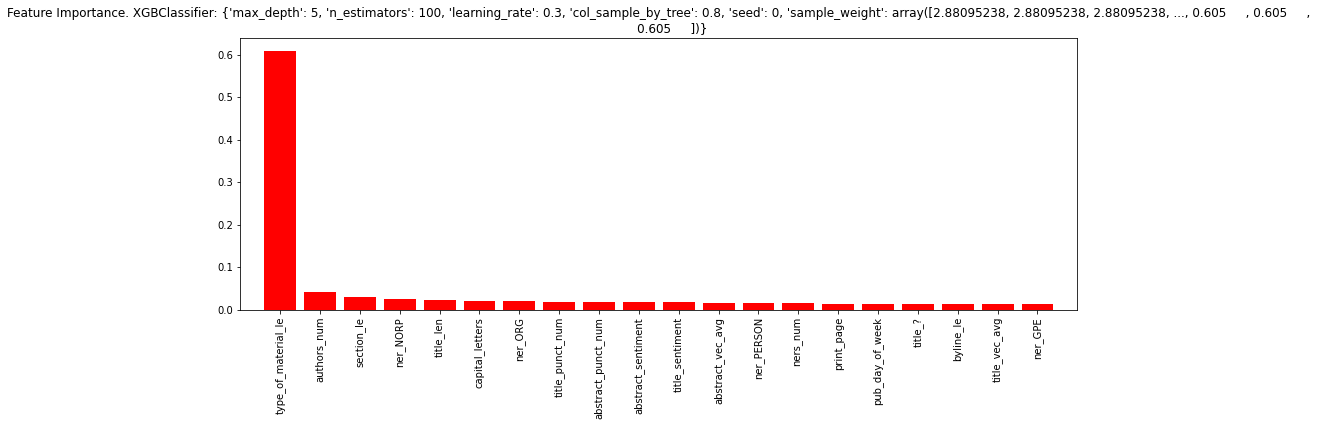

In [1102]:
run_cv_model(xgb.XGBClassifier, {'max_depth':5, 'n_estimators':100, 'learning_rate':0.3, 'col_sample_by_tree':0.8, 'seed':0, 'sample_weight':compute_sample_weight("balanced", y)}, X,y, get_feats(df))

In [1103]:
def run_cv_model_wo_feats(model_cls, model_params, X, y, feats, cv=KFold(n_splits=5, random_state=2021, shuffle=True), scoring='f1',
                 plot_learning_curve=True, plot_confusion_matrix=True, plot_feature_importances=True):

    scores = cross_val_score(model_cls(**model_params), X, y, cv=cv, scoring=scoring)
    print('mean={}, std={}, scores={}'.format( np.round(np.mean(scores), 2), np.round(np.std(scores), 2), scores))
    
    model = None
    if plot_learning_curve:
        model = model_cls(**model_params)
        model.fit(X, y)
        title='Learning Curve. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_learning_curve(model, X, y, title=title,figsize=(15, 5), cv=cv, scoring=scoring);
    
    if plot_confusion_matrix:
        y_pred = cross_val_predict(model_cls(**model_params), X, y, cv=cv)
        title='Confusion Matrix. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.metrics.plot_confusion_matrix(y, y_pred, title=title, normalize=True, figsize=(20 ,10))

mean=0.71, std=0.09, scores=[0.7012987  0.76923077 0.525      0.78571429 0.74725275]


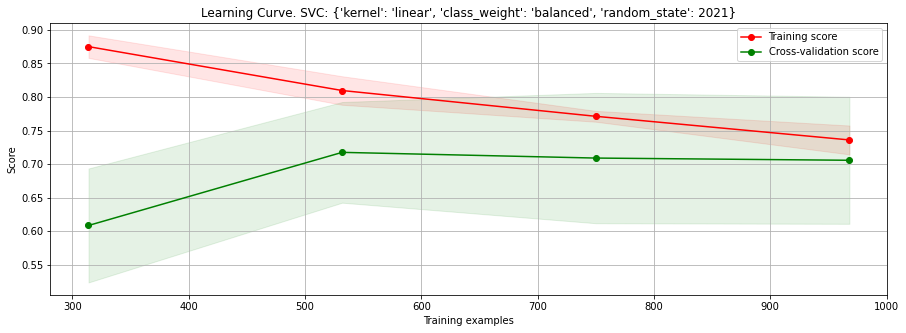

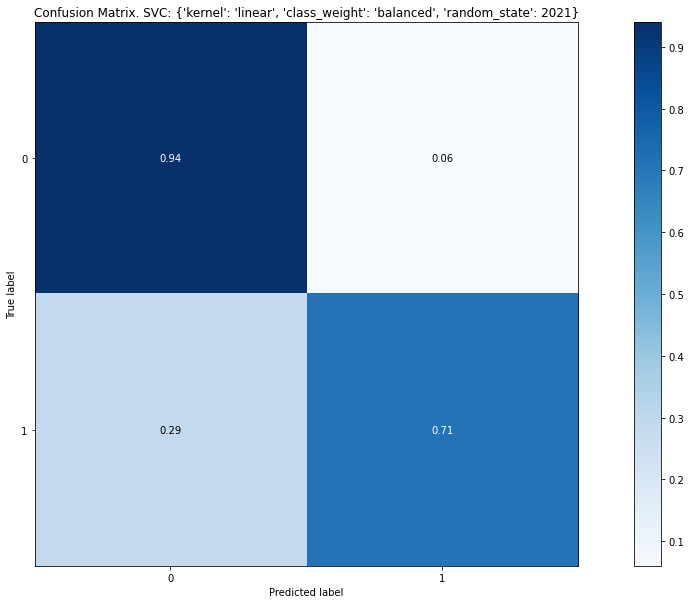

In [1104]:
run_cv_model_wo_feats(svm.SVC, {'kernel': 'linear', 'class_weight': 'balanced', 'random_state':2021}, X, df['class_le'], get_feats(df))

#Optymalizacja parametrów modelu

In [1105]:
def objective(space):
    
    DTC_params = {
        'max_depth': int(space['max_depth']),
        'min_weight_fraction_leaf': int(space['min_weight_fraction_leaf']),
        'max_features': int(space['max_features']),
        'max_leaf_nodes': int(space['max_leaf_nodes'])
    }
        
    model = DecisionTreeClassifier(**DTC_params, random_state=2021)
    cv = KFold(n_splits=5, random_state=2021, shuffle=True)
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        score = f1_score(y[test_idx], y_pred)
    
    return{'loss': -score, 'status': STATUS_OK}
    
space ={
    'max_depth': hp.quniform ('max_depth', 5, 20, 1),
    'random_state': hp.quniform ('random_state', 0, 10000, 50),
    'min_weight_fraction_leaf': hp.quniform ('min_weight_fraction_leaf', 0, 0.9, 0.1),
    'max_features': hp.quniform ('max_features', 1, 9, 1),
    'max_leaf_nodes': hp.quniform ('max_leaf_nodes', 2, 100, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

100%|██████████| 30/30 [00:01<00:00, 26.41it/s, best loss: -0.8311688311688311]
The best params:  {'max_depth': 19.0, 'max_features': 3.0, 'max_leaf_nodes': 17.0, 'min_weight_fraction_leaf': 0.30000000000000004, 'random_state': 5450.0}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1131, in f1_score
    zero_division=zero_division,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1270, in fbeta_score
    zero_division=zero_

mean=nan, std=nan, scores=[nan nan nan nan nan]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1131, in f1_score
    zero_division=zero_division,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1270, in fbeta_score
    zero_division=zero_division,
  File "/usr/local/lib/p

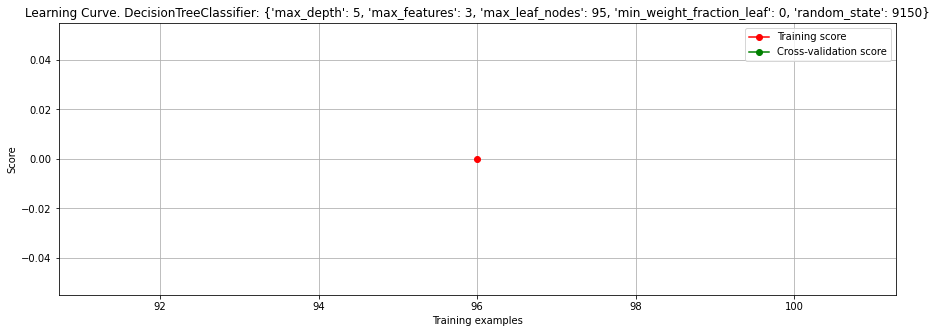

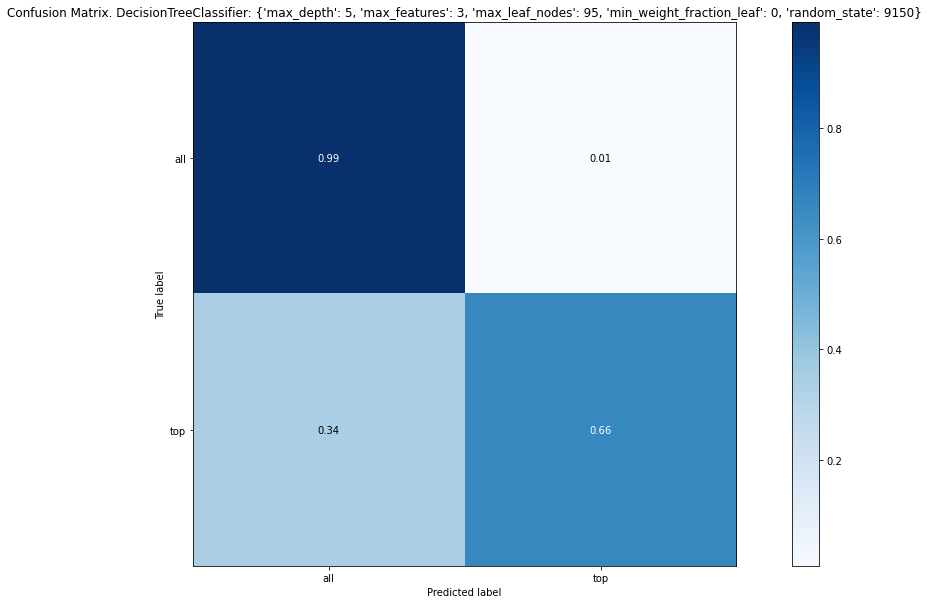

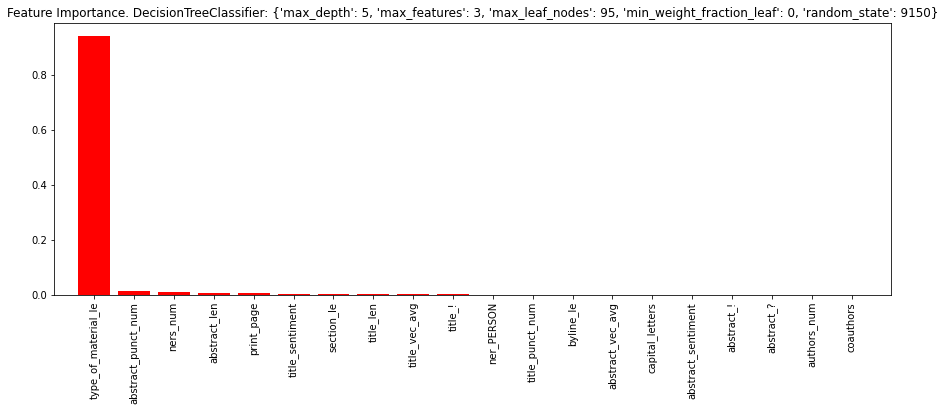

In [1130]:
run_cv_model(DecisionTreeClassifier, {'max_depth': 5, 'max_features': 3, 'max_leaf_nodes': 95, 'min_weight_fraction_leaf': 0, 'random_state': 9150}, X,y, get_feats(df))

Próba klasyfikacji

In [1107]:
def get_feats(df, black_list=['class_le']):
    return [x for x in df.select_dtypes(['number', 'bool']).columns if x not in black_list]

def get_X_y(df, feats=None):
    if feats is None:
        feats = get_feats(df)
        
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(df[feats].values)
    y=df['class'].values
    
    return X, y, scaler

X, y, scaler = get_X_y(df)

def model_train_predict(model, X, y, test_size=0.3):
    X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
    
    cv = KFold(n_splits=5, random_state=2021, shuffle=True)
    scores=[]
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        
    score = f1_score(y[test_idx], y_pred)
    scores.append(score)
    
    return score, y_pred, cv


In [1108]:
def cap_lett(message):
  n=0
  for x in message:
    if x.isupper():
      n += 1
  return n

def is_coauthor(authors_num):
  if authors_num > 1: 
    coauthors = 1
  else: 
    coauthors = 0
  return coauthors

def group_sections(section): 
    if section in ('Sports', 'Books', 'Movies', 'Crosswords & Games', 'Theater', 'Arts'):   #entertainment
      return 1
    elif section in ('Health', 'Style', 'Food', 'Well', 'Travel', 'Fashion & Style', 'Home & Garden', 'T Magazine'): #lifestyle
      return 2 
    elif section in ('Technology', 'Climate', 'Science', 'Education'): #knowlegde
      return 3
    elif section in ('Business', 'You Money', 'Real Estate', 'Business Day', 'Briefing'): #business
      return 4 
    elif section == 'World':
      return 5
    elif section in ('U.S.', 'New York'):
      return 6
    return 7            #others

def ners_GPE(x):
  if len(x) > 0 :
    for i in x:
      if i == 'GPE':
        return 1
      return 0
  else:
    return 0

def ners_PERSON(x):
  if len(x) > 0 :
    for i in x:
      if i == 'PERSON':
        return 1
      return 0
  else:
    return 0

def ners_ORG(x):
  if len(x) > 0 :
    for i in x:
      if i == 'ORG':
        return 1
      return 0
  else:
    return 0

def ners_MONEY(x):
  if len(x) > 0 :
    for i in x:
      if i == 'MONEY':
        return 1
      return 0
  else:
    return 0

def ners_NORP(x):
  if len(x) > 0 :
    for i in x:
      if i == 'NORP':
        return 1
      return 0
  else:
    return 0

In [1149]:
def model_gradio(Section, Byline, Title, Abstract, Print_Page, Type_of_material, Publication_date):
  byline_g = le_byline.transform(np.array(Byline).reshape(-1, 1)).item(0)
  title_clean_g = ' '.join([word for word in Title.lower().split() if word not in stopwords])  
  abstract_clean_g = ' '.join([word for word in Abstract.lower().split() if word not in stopwords])
  abstract_vec = np.mean(nlp(abstract_clean_g).vector)
  title_vec = np.mean(nlp(title_clean_g).vector)
  section_g = le_section.transform(np.array(Section).reshape(-1,1)).item(0)
  type_of_material_g = le_material.transform(np.array(Type_of_material).reshape(-1,1)).item(0)
  title_len = len(Title.split())
  abstract_len = len(Abstract.split())
  capital_letters = cap_lett(Title)
  title_punct_num = len([word for word in Title if word in string.punctuation])
  abstract_punct_num = len([word for word in Abstract if word in string.punctuation])
  title_exclamation = len([word for word in Title if word == "!"])
  title_question = len([word for word in Title if word == "?"])
  abstract_exclamation = len([word for word in Abstract if word == "!"])
  abstract_question = len([word for word in Abstract if word == "?"])
  authors_num = len([word for word in Byline if word == "," or word == 'and' or word == '&'])+1
  coauthors = is_coauthor(authors_num)
  sections_grouped = group_sections(Section)
  title_ner = nlp(Title).ents
  title_ner_type = [en.label_ for en in title_ner]
  title_ner_num = len(title_ner_type)
  ner_GPE = ners_GPE(title_ner_type)
  ner_PERSON = ners_PERSON(title_ner_type)
  ner_ORG = ners_ORG(title_ner_type)
  ner_MONEY = ners_MONEY(title_ner_type)
  ner_NORP = ners_NORP(title_ner_type)
  pub_date = pd.to_datetime(Publication_date)
  pub_day_of_week = pub_date.day_of_week
  title_sentiment = sent.polarity_scores(Title)['compound']
  abstract_sentiment = sent.polarity_scores(Abstract)['compound']
  print_page = Print_Page

  test_x = np.array([print_page, byline_g, section_g, type_of_material_g, title_vec, abstract_vec, title_len, abstract_len,
                    capital_letters, title_punct_num,  abstract_punct_num, title_exclamation, abstract_exclamation, title_question, abstract_question,
                     authors_num, coauthors, sections_grouped, title_ner_num, ner_GPE, ner_PERSON, ner_ORG, ner_MONEY, ner_NORP, 
                     pub_day_of_week, title_sentiment, abstract_sentiment])
  xscaled = scaler.transform(test_x.reshape(1,-1))
  params = {'kernel': 'linear', 'class_weight': 'balanced', 'random_state':2021}
  model = cls = SVC(**params) 
  model.fit(X, y)
  prediction = model.predict(xscaled).item(0)
  if prediction == 'top':
    prediction = 'yes 🥳'
  else:
    prediction = 'no 🙁'
  return prediction

In [1150]:
model_gradio("U.S.",'David E. Sanger, Julian E. Barnes and Kate Conger',  'As Tanks Rolled Into Ukraine, So Did Malware. Then Microsoft Entered the War.', 'After years of talks about the need for public-private partnerships to combat cyberattacks, the war in Ukraine is stress-testing the system.', 11,'News','2022-03-01')

'yes 🥳'

In [1151]:
model_gradio("U.S.",'Katharine Q. Seelye',  'Lynn Yeakel, Spurred Into Politics by Anita Hill, Dies at 80', 'She nearly unseated Senator Arlen Specter after his aggressive grilling of Ms. Hill during Clarence Thomas’s 1991 Supreme Court confirmation hearings.', 20,'Obituary (Obit)','2022-03-17')

'no 🙁'

In [1153]:
demo = gr.Interface(
    fn=model_gradio,
    inputs=[gr.Radio(['Arts', 'Automobiles', 'Books', 'Briefing', 'Business', 'Business Day', 'Climate', 'Crosswords & Games', 'Education','Fashion & Style', 'Food', 'Health',
       'Home & Garden', 'International Home', 'Magazine', 'Movies', 'New York', 'Obituaries', 'Opinion', 'Reader Center','Real Estate', 'Science', 'Special Series',
       'Sports', 'Style', 'Sunday Review','T Magazine', 'Technology', 'The Upshot','Theater', 'Times Insider', 'Travel','U.S.', 'Well', 'World', 'Your Money']), #section
       'text', #byline
       'text', #title
       'text', #abstract
       'number', #print page
       gr.Radio(['News', 'Op-Ed', 'Obituary (Obit)', 'Editorial', 'Review',
       'briefing', 'Letter', 'List', 'News Analysis']), #type of material
       'text' #publication date
       ],
    outputs='text',
    title='Is this article top shared?'
)

demo.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://14824.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7fa6e36d5dd0>,
 'http://127.0.0.1:7870/',
 'https://14824.gradio.app')

#SIEĆ REKURENCYJNA

In [1113]:
X_train, X_test, Y_train, Y_test = train_test_split(X, df['class_le'], test_size=0.3, random_state=2)
n_features = X.shape[1]
n_classes = 2
print('X_train shape: ', X_train.shape) 
print('n_features: ', n_features) 
print('n_classes: ', n_classes) 

X_train shape:  (847, 27)
n_features:  27
n_classes:  2


In [1114]:
model = models.Sequential()
model.add(layers.Dense(1, input_dim=n_features, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))

In [1115]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 1)                 28        
                                                                 
 dense_19 (Dense)            (None, 2)                 4         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


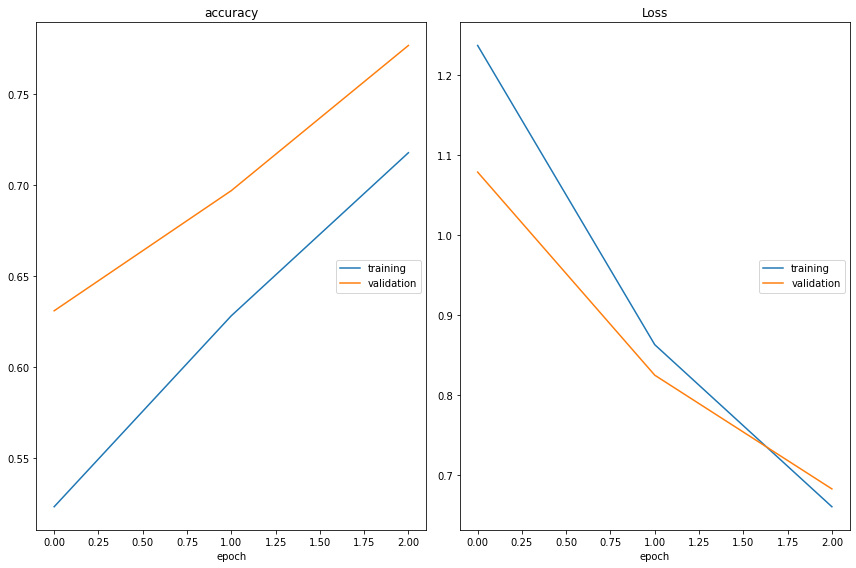

accuracy
	training         	 (min:    0.523, max:    0.718, cur:    0.718)
	validation       	 (min:    0.631, max:    0.777, cur:    0.777)
Loss
	training         	 (min:    0.661, max:    1.237, cur:    0.661)
	validation       	 (min:    0.683, max:    1.079, cur:    0.683)
170/170 [==============================] - 1s 6ms/step - loss: 0.6607 - accuracy: 0.7178 - val_loss: 0.6830 - val_accuracy: 0.7769


In [1116]:
model.fit(X_train, Y_train, batch_size=5, epochs=3, verbose=1, validation_data=(X_test, Y_test), callbacks=[PlotLossesKeras()])

In [1117]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.6829679012298584
Test accuracy:  0.7768595218658447


In [1118]:
df.to_csv('./df_klasyfikacja_small.csv')

In [1119]:
import plotly.express as px

In [1120]:
def to_1D(series):
    return pd.DataFrame([x for _list in series for x in _list],columns=['country'])

In [1121]:
df['countries'] = ent.map(lambda e: [en.text for en in e if en.label_ == "GPE"])

In [1122]:
all_countries = to_1D(df['countries'])
all_countries['weight'] = 1
all_countries

,country,weight
0,Russia,1
1,Ukraine,1
2,Switzerland,1
3,Texas,1
4,Kyiv,1
...,...,...
398,Florida,1
399,Russia,1
400,Ontario,1
401,Ukraine,1


In [1123]:
states=['Texas', 'Minneapolis', 'Washington', 'Florida', 'Seattle', 'Oklahoma', 'Utah', 'Georgia', 'New York City Sewage', 'N.J.', 'Pennsylvania',  'New York', 'Los Angeles', 'Ohio','Kentucky', 'Philadelphia',  'Long Island', 'Virginia',
'Wisconsin',  'California', 'Iowa', 'New York City’s', 'Ontario', 'New York City','Oregon', 'Washington State', 'D.C.', 'Indiana', 'Maryland', 'Idaho', 'Brooklyn',  'N.Y.', 'New York’s', 'Connecticut',  'Manhattan', 'Albany', 'Palm Beach',  
'Oakland', 'Buffalo', 'Cleveland','Louisville', 'Rowayton', 'Conn.', 'Jackson','San Francisco', 'Michigan', 'Illinois', 'Hawaii', 'South Carolina','Nevada', 'Westchester', 'Suffolk', 'Alaska', 'Riverhead', 'Colorado', 'Atlanta', 'Missouri', 
'Alabama','Arizona', 'Hollywood','Us','the United States']

In [1124]:
US_dict = dict.fromkeys(states, 'U.S.')

In [1125]:
countries_dict = {'Ukrainian':'Ukraine','Bucha':'Ukraine', 'Kyiv':'Ukraine', 'Ukraine City Near':'Ukraine', 'Lviv':'Ukraine', 'Mariupol':'Ukraine', 'Donbas':'Ukraine', 
                  'Moscow':'Russia', 'Shanghai':'China', 'Hong Kong':'China', 'Beijing':'China', 'North Korea’s':'North Korea', 'Quebec':'Canada',
                  'Paris':'France', 'Geneva':'Switzerland', 'London':'U.K.', 'Britain':'U.K.'}

In [1126]:
all_countries.replace({'country':US_dict}, inplace=True)
all_countries.replace({'country':countries_dict}, inplace=True)

In [1127]:
grouped = all_countries.groupby('country').sum() 
grouped = grouped.reset_index()

In [1128]:
fig = px.choropleth(grouped, locations='country', locationmode='country names', 
                     color='weight',  projection = 'natural earth',
                     range_color= [0, max(grouped['weight'])], 
                    labels={'weight':'Liczba wystąpień'},
                     title='Kraje, których dotyczą artykuły')

fig.show()